In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import comet_ml
from comet_ml import Experiment

In [3]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CometLogger

In [4]:
from manifoldembedder import *

In [5]:
train_file_list = []
val_file_list = []
test_file_list = []
predict_file_list = []

for file in os.listdir('/nobackup/users/sangeon/datasets/mnist'):
    if "train" in file:
        train_file_list.append(os.path.join('/nobackup/users/sangeon/datasets/mnist',file))
    elif "val" in file:
        val_file_list.append(os.path.join('/nobackup/users/sangeon/datasets/mnist',file))
    elif "predict" in file:
        predict_file_list.append(os.path.join('/nobackup/users/sangeon/datasets/mnist',file))
    elif "test" in file:
        test_file_list.append(os.path.join('/nobackup/users/sangeon/datasets/mnist',file))

In [6]:
file_dict = {'train':train_file_list,
             'val':val_file_list,
             'test':test_file_list,
             'predict':predict_file_list}

In [7]:
mnistpair_dm = MNISTPairDataModule(file_dict,10000)

In [11]:
model = ManifoldEmbedder("MNIST","CNN", 1e-4, 2, [1000,500,10])


In [12]:
experiment = Experiment(
    api_key="CkkrVkSk6Vr2WKlbXIzlkhNlE",
    project_name="metricembedder_MNIST",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sangeonpark/metricembedder-mnist/d0f32157e43f48bea38000feb7c38b71



In [13]:
comet_logger = CometLogger(
    api_key="CkkrVkSk6Vr2WKlbXIzlkhNlE",
    project_name="metricembedder_MNIST",
)

CometLogger will be initialized in online mode


In [14]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=False)

In [15]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/home/sangeon/ToyJetGenerator/training/mnist_checkpoints",
    filename="MNIST-CNN3-mseloss-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=4,
    mode="min",
)

In [16]:
trainer = Trainer(gpus=1,callbacks=[PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=comet_logger,auto_lr_find=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Starting to init trainer!
Trainer is init now


In [17]:
trainer.fit(model, mnistpair_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/sangeonpark/metricembedder-mnist/d0f32157e43f48bea38000feb7c38b71
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (176.46 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sangeonpark/metricembe

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [16]:
a = trainer.predict(model, mnistpair_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sangeonpark/metricembedder-mnist/e43a73551b2a41a4993b1eee6636928f

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 500it [00:00, ?it/s]

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:172: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")
COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/sangeonpark/metricembedder-mnist/e43a73551b2a41a4993b1eee6636928f
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: -----------------------------------
COMET INFO: Uploading 1 metrics, params and output messages


In [17]:
label = np.array([])
embedding = np.empty((0,2))
for batch in a:
    #print(batch[0].shape)
    embedding = np.vstack((embedding, batch[0].cpu().numpy()))
    label = np.concatenate([label, batch[1].cpu().numpy()])
    #print(batch[0], batch[1])

In [18]:
embedding[label==7]

array([[ 0.25831637, -0.28009054],
       [ 0.20964539, -0.31149802],
       [ 0.20615447, -0.31669468],
       ...,
       [ 0.25960132, -0.26633662],
       [ 0.24644527, -0.27207503],
       [ 0.25230032, -0.27972844]])

In [20]:
embedding[label==1]

array([[ 0.26749909, -0.26002491],
       [ 0.26451105, -0.259969  ],
       [ 0.26055133, -0.27445769],
       ...,
       [ 0.25307065, -0.21810097],
       [ 0.26123977, -0.27096078],
       [ 0.26319772, -0.25936228]])

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 14})

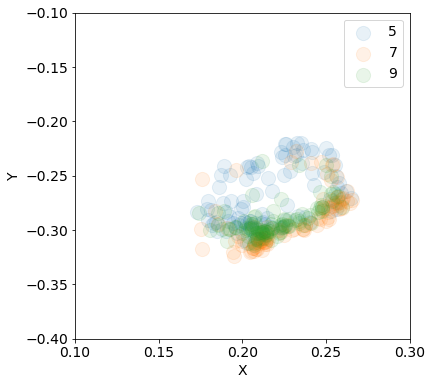

In [44]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.scatter(embedding[label==0][:100,0],embedding[label==0][:100,1],s=200,alpha=0.1,label='0')
#ax.scatter(embedding[label==1][:100,0],embedding[label==1][:100,1],s=200,alpha=0.1,label='1')
#ax.scatter(embedding[label==2][:100,0],embedding[label==2][:100,1],s=200,alpha=0.1,label='2')
#ax.scatter(embedding[label==3][:100,0],embedding[label==3][:100,1],s=200,alpha=0.1,label='3')
#ax.scatter(embedding[label==4][:100,0],embedding[label==4][:100,1],s=200,alpha=0.1,label='4')
ax.scatter(embedding[label==5][:100,0],embedding[label==5][:100,1],s=200,alpha=0.1,label='5')
#ax.scatter(embedding[label==6][:100,0],embedding[label==6][:100,1],s=200,alpha=0.1,label='6')
ax.scatter(embedding[label==7][:100,0],embedding[label==7][:100,1],s=200,alpha=0.1,label='7')
#ax.scatter(embedding[label==8][:100,0],embedding[label==8][:100,1],s=200,alpha=0.1,label='8')
ax.scatter(embedding[label==9][:100,0],embedding[label==9][:100,1],s=200,alpha=0.1,label='9')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim([0.1,.3])
ax.set_ylim([-0.4,-.1])
ax.legend()
fig.savefig(f'../figures/embedding_MNIST2_579.png')